In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

- 목표: 특정 데이터가 주어졌을 때 구역의 중간 주택 가격을 예측하기
- 머신러닝 방법:
  - 레이블 된 훈련 샘플이 있다 -> 지도학습
  - 집 값을 예측한다 -> 회귀
  - 예측에 사용할 특성이 여러개이다 -> 다중회귀
  - 각 구역마다 하나의 값을 예측한다 -> 단변량 회귀


# 2.3) 데이터 불러오기

In [ ]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/'
HOUSING_PATH = os.path.join('datasets','housing') # 데이터셋이 저장될 디렉토리 경로
HOUSING_URL = DOWNLOAD_ROOT + 'datasets/housing/housing.tgz' # 데이터셋 tar파일의 전체 URL


# 지정된 url에서 압축된 tar 파일을 다운로드하고, 그 내용을 지정된 디렉토리에 추출
def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    os.makedirs(housing_path, exist_ok = True)
    tgz_path = os.path.join(housing_path, 'housing.tgz')
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path = housing_path)
    housing_tgz.close()

In [ ]:
def load_housing_data(housing_path= HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

In [ ]:
fetch_housing_data()

In [ ]:
housing=  load_housing_data()

# 데이터 EDA(Exploratory Data Analysis)
- Descriptive statistics: Calculating measures such as mean, median, mode, standard deviation, and range to summarize the central tendency, spread, and distribution of the data.
- Data visualization: Creating charts, graphs, and plots to visually represent the data, such as histograms, scatter plots, box plots, and heatmaps.
- Data cleaning and preprocessing: Handling missing values, dealing with outliers, and transforming variables to ensure data quality and consistency.
- Correlation analysis: Examining the relationships between variables to understand their strength and direction, often using correlation matrices or correlation coefficients.
- Feature engineering: Creating new variables or transforming existing ones based on domain knowledge or patterns observed during analysis.
- Hypothesis testing: Formulating and testing statistical hypotheses to validate or reject assumptions about the data.
- Data segmentation: Grouping data based on certain criteria or characteristics to gain insights into different subsets or clusters.
- Dimensionality reduction: Reducing the number of variables or features to focus on the most informative ones using techniques like principal component analysis (PCA) or feature selection methods.

In [ ]:
housing.info()

In [ ]:
housing['ocean_proximity'].value_counts()

In [ ]:
housing.describe()

* 왜도(Skewness)
  - 분포의 비대칭도
  - 정규분포의 왜도 = 0
  - 왜도 > 0 : 왼쪽으로 치우침
  - 왜도 < 0 : 오른쪽으로 치우침
  - 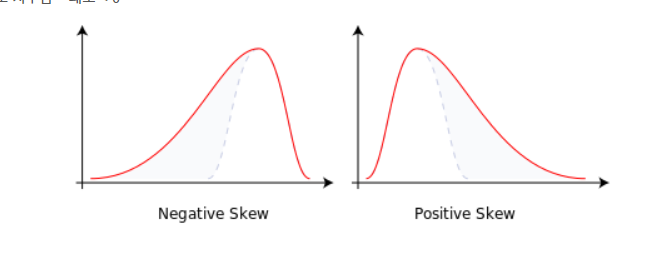
  - 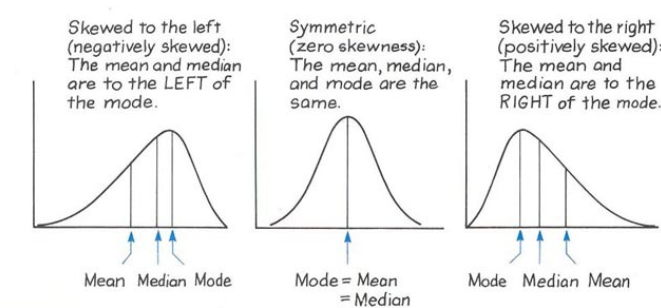

In [ ]:
housing.skew().sort_values()

In [ ]:
housing['longitude'].skew()

* 첨도(Kurtosis)
  * 확률분포의 뾰족한 정도
  * 관측치들이 얼마나 집중적으로 중심에 몰렸는가?
  * 정규분포 = 첨도 0 (pearson 첨도 =3)
  * 첨도>0 : 위로 뾰족
  * 첨도<0 : 정규분포보다 더 완만하고 납작한 분포


In [ ]:
housing.kurt().sort_values()

In [ ]:
# displot통해 히스토그램과 kdeplot그리기

def get_displot(df):
    for column in df.columns:
        sns.displot(data=df, x=column, kde=True)
        plt.title('Skew: {:.2f}, Kurt: {:.2f}'.format(df[column].skew(), df[column].kurt()))
        plt.show()


In [ ]:
get_displot(housing)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

housing.hist(bins=50, figsize=(20,15))
plt.show()

<EDA 결과>
- median_income은 US dollar로 표현되어 있지 않음
- housing_median_age와 median_house_value는 꼬리 부분에 값이 몰려있는 것으로 봐서 최대값 최솟값을 미리 한정해놓은 듯
  - 이러한 경우 한계값 밖의 정확한 데이터를 얻거나
  - 해당 구역을 제거함으로써 데이터 처리

- feature들의 scale이 모두 다르다. 스케일링 필요
- 모두 오른쪽으로 긴 꼬리를 가지고 있다. 좀 더 종모양의 분포가 되도록 조정 필요

# Data split

If real estate expert said median_income is very important to predict housing value? --> Then we need to split data set based on median_income!

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.3, random_state=42)

In [ ]:
housing['income_cat'] = pd.cut(housing['median_income'],
                               bins=[0, 1.5, 3, 4.5, 6, np.inf],
                               labels=[1,2,3,4,5])

In [ ]:
housing

In [179]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [ ]:
strat_test_set['income_cat'].value_counts()/len(strat_test_set)

In [ ]:
housing['income_cat'].value_counts()/len(housing['income_cat'])

In [ ]:
housing.drop('income_cat')


# 2.4)데이터 탐색, 시각화

### 주택 밀집 지역(위도,경도)에 따른 산점도

In [ ]:
plt.scatter(data=housing, x='longitude', y='latitude',alpha=0.4,
            s=housing['population']/100, c='median_house_value',
            label ='population'
            )
plt.legend()

### 상관관계 조사

In [ ]:
corr_matrix = housing.corr()

In [ ]:
corr_matrix['median_house_value'].sort_values(ascending=False)

In [ ]:
sns.pairplot(housing[['median_house_value','median_income','total_rooms','housing_median_age']])

In [ ]:
housing.plot(x='median_income',y='median_house_value',kind='scatter',alpha=0.1)

plot확인해본 결과
- median_house_value와 median_income의 상관관계는 매우 강함
- 가격 제한값이 500000으로 잘 보임. 그러나 비슷한 직선이 450000, 350000 등에도 보임. 이러한 구역은 제거하는 것이 좋아보임

### 특성조합

In [ ]:
housing.columns

In [ ]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_bedrooms']
housing['population_per_household'] = housing['population']/housing['households']


In [ ]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

# 2.5) 머신러닝 알고리즘을 위한 데이터 준비

## 2.5.1_ 데이터 정제
- op 1. 해당 구역 제거 : dropna()
- op 2. 전체 특성 삭제 : drop()
- op 3. 어떤 값으로 채우기 : fillna()

In [210]:
housing  = strat_train_set.drop('median_house_value',axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

In [212]:
housing.shape, housing_labels.shape

((16512, 13), (16512,))

In [213]:
# null값 확인
housing.isnull().sum()

longitude                     0
latitude                      0
housing_median_age            0
total_rooms                   0
total_bedrooms              158
population                    0
households                    0
median_income                 0
ocean_proximity               0
income_cat                    0
rooms_per_household           0
bedrooms_per_room           158
population_per_household      0
dtype: int64

In [182]:
# # op 1
# housing.dropna(subset=['total_bedrooms']) 

# # op2
# housing.drop('total_bedrooms',axis=1) 

# # op 3
# median = housing['total_bedrooms'].median()
# housing['total_bedrooms'].fillna(median, inplace=True)

- SimpleImputer: 누락된 값(null값)을 손쉽게 다룰 수 있게 해주는 툴 (수치형 데이터만 가능)

In [214]:
# SimpleImputer : 누락된 값을 손쉽게 다루도록 해줌
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
# imputer는 strategy인 중간값을 계산해서 statistics_ 속성에 저장해놓음

In [215]:
# median은 수치형에서만 계산될 수 있기때문에 housing['ocean_proximity] 제외한 df 생성
housing_num = housing.drop('ocean_proximity',axis=1)

In [216]:
# fit method 사용해서 훈련 데이터에 적용
# housing_num의 중앙값을  imputer에 훈련(fit)
imputer.fit(housing_num) 

SimpleImputer(strategy='median')

In [217]:
imputer.statistics_ # imputer에 저장된 median값

array([-1.18510000e+02,  3.42600000e+01,  2.90000000e+01,  2.11900000e+03,
        4.33000000e+02,  1.16400000e+03,  4.08000000e+02,  3.54155000e+00,
        3.00000000e+00,  5.23234164e+00,  1.00000000e+00,  2.81766108e+00])

In [218]:
housing_num.median().values

C:\Users\TEMP\AppData\Local\Temp\ipykernel_2112\3605723347.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  housing_num.median().values


array([-1.18510000e+02,  3.42600000e+01,  2.90000000e+01,  2.11900000e+03,
        4.33000000e+02,  1.16400000e+03,  4.08000000e+02,  3.54155000e+00,
        5.23234164e+00,  1.00000000e+00,  2.81766108e+00])

In [219]:
X = imputer.transform(housing_num)

In [189]:
housing_tr = pd.DataFrame(X, columns= housing_num.columns,
                          index = housing_num.index)
housing_tr.isnull().sum()

longitude                   0
latitude                    0
housing_median_age          0
total_rooms                 0
total_bedrooms              0
population                  0
households                  0
median_income               0
income_cat                  0
rooms_per_household         0
bedrooms_per_room           0
population_per_household    0
dtype: int64

- 텍스트와 범주형 특성 다루기

In [190]:
housing_cat = housing[['ocean_proximity']]

In [191]:
housing_cat.value_counts()

ocean_proximity
<1H OCEAN          7277
INLAND             5262
NEAR OCEAN         2124
NEAR BAY           1847
ISLAND                2
dtype: int64

- OrdinalEncoder(순서가 있는 경우, 점수같은..)

In [192]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [193]:
np.unique(housing_cat_encoded)

array([0., 1., 2., 3., 4.])

In [194]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

- OneHotEncoder

In [195]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [196]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [197]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

- 나만의 변환기

In [198]:
housing_num.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,income_cat,rooms_per_household,bedrooms_per_room,population_per_household
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,2,5.485836,1.0,3.168555
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,5,6.927083,1.0,2.623698
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,2,5.393333,1.0,2.223333
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,2,3.886128,1.0,1.859213
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,3,6.096552,1.0,3.167241


In [199]:
housing.values

array([[-121.46, 38.52, 29.0, ..., 5.485835694050992, 1.0,
        3.168555240793201],
       [-117.23, 33.09, 7.0, ..., 6.927083333333333, 1.0,
        2.6236979166666665],
       [-119.04, 35.37, 44.0, ..., 5.3933333333333335, 1.0,
        2.223333333333333],
       ...,
       [-122.72, 38.44, 48.0, ..., 4.1104651162790695, 1.0,
        2.6627906976744184],
       [-122.7, 38.31, 14.0, ..., 6.297405189620759, 1.0,
        2.411177644710579],
       [-122.14, 39.97, 27.0, ..., 5.477157360406092, 1.0,
        3.1725888324873095]], dtype=object)

In [227]:
from sklearn.base import BaseEstimator, TransformerMixin

room_idx, bedroom_idx, population_idx, household_idx = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        rooms_per_household = X[:,room_idx]/X[:,household_idx]
        population_per_household = X[:,population_idx]/X[:,household_idx]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedroom_idx]/X[:,room_idx]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)


In [201]:
housing_extra_attribs

array([[-121.46, 38.52, 29.0, ..., 3.168555240793201, 5.485835694050992,
        3.168555240793201],
       [-117.23, 33.09, 7.0, ..., 2.6236979166666665, 6.927083333333333,
        2.6236979166666665],
       [-119.04, 35.37, 44.0, ..., 2.223333333333333, 5.3933333333333335,
        2.223333333333333],
       ...,
       [-122.72, 38.44, 48.0, ..., 2.6627906976744184,
        4.1104651162790695, 2.6627906976744184],
       [-122.7, 38.31, 14.0, ..., 2.411177644710579, 6.297405189620759,
        2.411177644710579],
       [-122.14, 39.97, 27.0, ..., 3.1725888324873095, 5.477157360406092,
        3.1725888324873095]], dtype=object)

- 특성 스케일링
  - 입력 숫자 특성들의 스케일이 많이 다르면 잘 작동하지 않음
  - 타깃값에 대한 스케일링은 일반적으로 불필요
  - minmax: 
    - (데이터-최솟값)/(최댓값-최솟값)
    - 정규화(normalization)
    - 이상치에 영향-> 만약 중간소득을 잘못해서 100이라 입력했다.
      - 그렇다면 minmax는 0~15사이의 모든 다른값을 0~0.15로 만들어버림

  - standard scaler:
    - 표준화
    - (데이터-평균)/표준편차 
    - 분포의 분산이 1이 되도록 하는 것
    - 이상치에 영향을 덜 받음

- 변환 파이프라인

In [202]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),  #(이름, 추정기)
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

NameError: name 'self' is not defined

In [203]:
housing_num_tr

array([[-1.32783522,  1.05254828,  0.98214266, ...,  0.62855945,
        -0.04959654, -1.02998783],
       [-1.32284391,  1.04318455, -0.60701891, ...,  0.32704136,
        -0.09251223, -0.8888972 ],
       [-1.33282653,  1.03850269,  1.85618152, ...,  1.15562047,
        -0.02584253, -1.29168566],
       ...,
       [-0.8237132 ,  1.77823747, -0.92485123, ..., -0.09031802,
        -0.0717345 ,  0.02113407],
       [-0.87362627,  1.77823747, -0.84539315, ..., -0.04021111,
        -0.09122515,  0.09346655],
       [-0.83369581,  1.75014627, -1.00430931, ..., -0.07044252,
        -0.04368215,  0.11327519]])

In [229]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']


full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
    

])

housing_prepared = full_pipeline.fit_transform(housing)

NameError: name 'self' is not defined

In [205]:
housing_prepared

array([[-1.32783522,  1.05254828,  0.98214266, ...,  0.        ,
         1.        ,  0.        ],
       [-1.32284391,  1.04318455, -0.60701891, ...,  0.        ,
         1.        ,  0.        ],
       [-1.33282653,  1.03850269,  1.85618152, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.8237132 ,  1.77823747, -0.92485123, ...,  0.        ,
         0.        ,  0.        ],
       [-0.87362627,  1.77823747, -0.84539315, ...,  0.        ,
         0.        ,  0.        ],
       [-0.83369581,  1.75014627, -1.00430931, ...,  0.        ,
         0.        ,  0.        ]])

# 모델 선택과 훈련

In [209]:
housing_prepared.shape, housing_labels.shape

((20640, 21), (16512,))

In [207]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

ValueError: Found input variables with inconsistent numbers of samples: [20640, 16512]